#Locally adaptive Bayesian covariance regression:
## Making test data

Here, we follow the algorithm given in [Durante, Scarpa, and Dunson (2014)](https://www.researchgate.net/profile/David_Dunson/publication/232063211_Locally_adaptive_factor_processes_for_multivariate_time_series/links/09e4150df41e8d582a000000.pdf). The description in the paper is a bit sketchy, but we are following Section 4.1.

In [1]:
using PyPlot
using Distributions
plt.style[:use]("ggplot")
srand(12347)

Base.Random.MersenneTwister(Base.dSFMT.DSFMT_state(Int32[-27667103,1073483597,189278614,1073164175,2057630276,1072701164,1574415675,1073236915,-1738475538,1073062896  …  1573891607,1073551291,-124871223,1072938952,1051906677,1540499365,14352668,2066903520,382,32674]),[1.77573,1.97378,1.08523,1.3952,1.06599,1.24399,1.42131,1.74839,1.93799,1.68449  …  1.33615,1.45354,1.16443,1.79695,1.56358,1.50672,1.26924,1.5313,1.82524,1.69371],382,UInt32[0x0000303b])

### Set parameters

In [2]:
Np = 5  # dimension of observation 
NL = 2  # Left dimension of \Theta
NK = 2  # Right dimension of \Theta

2

### Make $\xi(t)$

The $\Xi(t)$ matrix is $L \times K$. Each $\xi_{lk}(t), t \in [0, 1]$ is like a "bumps" function from [Donoho and Johnstone (1994)](http://biomet.oxfordjournals.org/content/81/3/425.short).

In [3]:
# bump kernel function
function K_bumps(t::Float64)
    return (1 + abs(t))^-4
end

# make weighted kernel function
function make_curve(nbumps, kern, max_scale, weight_range, tobs)
    kern_locs = sort(rand(nbumps))
    kern_scales = max_scale * rand(nbumps)
    kern_list = [(t -> kern((t - ti) / s)) for (ti, s) in zip(kern_locs, kern_scales)]
    w_min, w_max = weight_range
    weights = w_min + (w_max - w_min) * rand(nbumps)
    K_mat = [f(t) for f in kern_list, t in tobs]
    return weights' * K_mat
end

make_curve (generic function with 1 method)

Sanity check:

(101

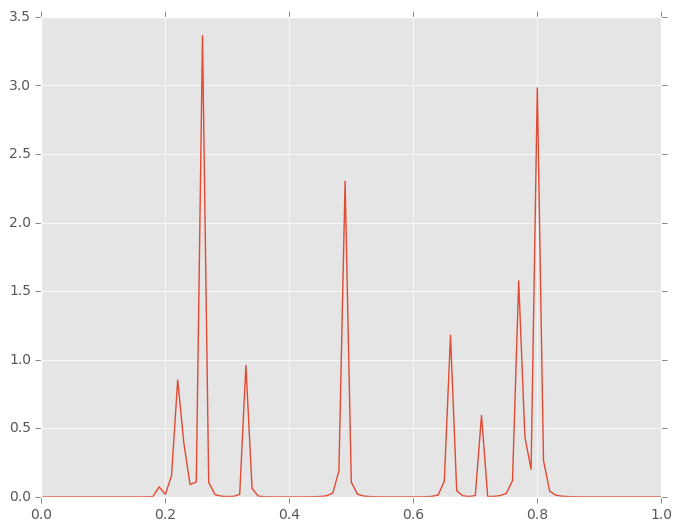

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31fc37450>

,)


In [4]:
tobs = collect(0:0.01:1)  # observation points
Nt = length(tobs)
println(size(tobs))

bumps = make_curve(11, K_bumps, 0.01, (3, 6), tobs)

plot(tobs, bumps')

Now make a matrix of these:

In [5]:
ξ = Array(Float64, Nt, NL, NK)

for l in 1:NL, k in 1:NK
    ξ[:, l, k] = make_curve(11, K_bumps, 0.01, (3, 6), tobs)
end

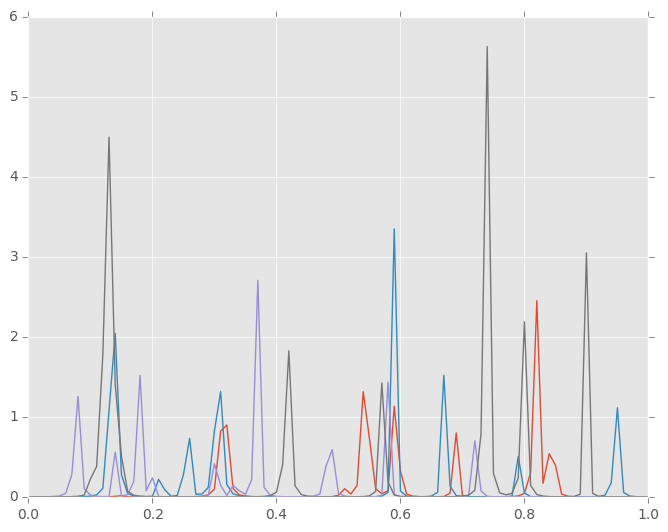

In [6]:
for l in 1:NL, k in 1:NK
    plot(tobs, ξ[:, l, k])
end

### Make $\psi(t)$

The $K$-vector $\Psi(t)$ is the mean of each dictionary element, drawn from a Gaussian process with standard $e^{-|x-x'|^2/\kappa^2}$ kernel.

In [7]:
# make enormous covariance matrix
κ = 0.1  # is 10 in Durante et al., but we include rescaling by 100
dist_mat = Float64[exp(-(ti - tj)^2/κ^2)  for ti in tobs, tj in tobs]

# handle near singularity of matrix by adding a ridge noise term
toler = 1e-9
dist_mat += scale(toler, eye(Nt))  # add a ridge term

ψ = Array(Float64, Nt, NK)

for k in 1:NK
    ψ[:, k] = rand(MvNormal(dist_mat))
end

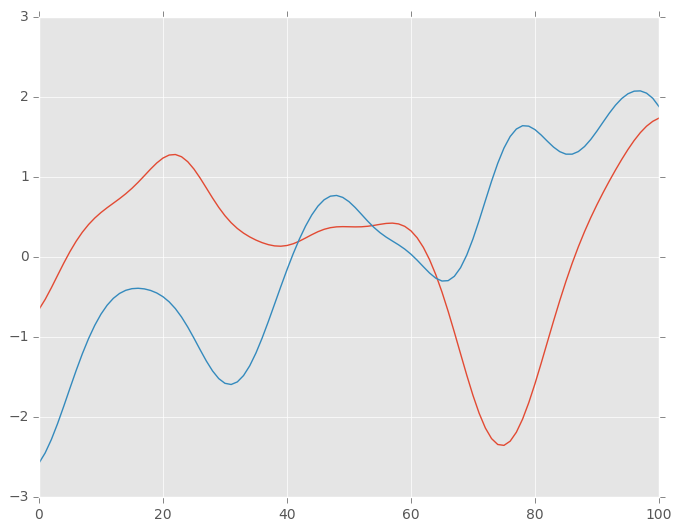

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32094cf10>
 PyObject <matplotlib.lines.Line2D object at 0x3209591d0>

In [8]:
plot(ψ)

### Make $\Theta$

From Durante et al., we have 

$$\begin{align}
\theta_{jl} &\sim \mathcal{N}(0, \phi_{jl}^{-1} \tau_l^{-1}) \\
\phi_{jl} &\sim \mathrm{Ga}\left(\frac{3}{2}, \frac{3}{2} \right) \\
\tau_l &= \prod_h^l \vartheta_h \\
\vartheta_1 &\sim \mathrm{Ga}(a_1, 1) \\
\vartheta_h &\sim \mathrm{Ga}(a_2, 1) \quad h \ge 2
\end{align}$$

In [9]:
function draw_θ(p, L, a1, a2)
    ϕ = rand(Gamma(3//2, 3//2), p, L)
    th = Array(Float64, L)
    th[1] = rand(Gamma(a1, 1))
    th[2:end] = rand(Gamma(a2, 1), L - 1)
    τ = cumprod(th)
    σ = 1 ./ map(sqrt, (ϕ .* τ'))
    θ = randn(p, L) .* σ
    return θ
end

draw_θ (generic function with 1 method)

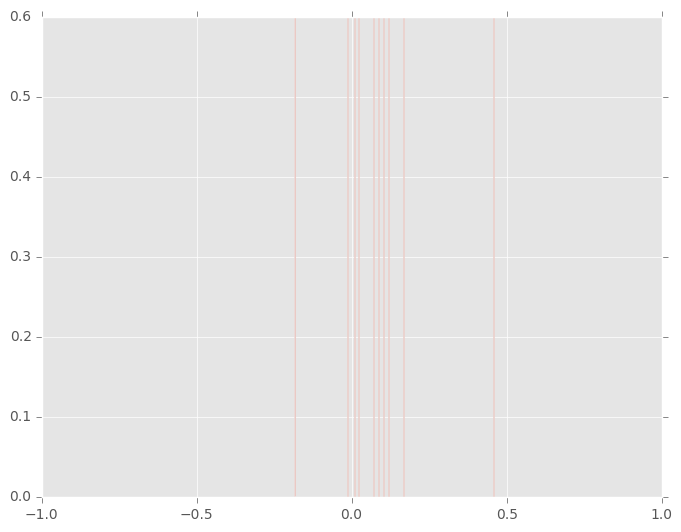

(-1,1)

In [10]:
Theta = draw_θ(Np, NL, 10, 10)

plt.hist(Theta[:], 200, normed=true)
plt.ylim(0, 0.6)
plt.xlim(-1, 1)

### Make $\Sigma_0$

This is the channel-specific piece of the covariance matrix.

In [11]:
prec0 = rand(Gamma(1, 0.1), Np)

Σ0 = diagm(1 ./ prec0)

5x5 Array{Float64,2}:
 24.7851  0.0       0.0     0.0      0.0    
  0.0     7.22569   0.0     0.0      0.0    
  0.0     0.0      39.2552  0.0      0.0    
  0.0     0.0       0.0     3.74415  0.0    
  0.0     0.0       0.0     0.0      3.38035

## Simulate data

We use the model given by 

$$\begin{align}
\mu(t) &= \Theta \xi(t) \psi(t) \\
y(t) &= \mu(t) + \epsilon_t \\
\epsilon_t &\sim \mathcal{N}(0, \Sigma_0)
\end{align}$$

In [12]:
y = Array(Float64, Nt, Np)
noise = 0.001 * rand(MvNormal(Σ0), Nt)

for t in 1:Nt
    y[t, :] = Theta * slice(ξ, t, :, :) * slice(ψ, t, :) + noise[:, t]
end

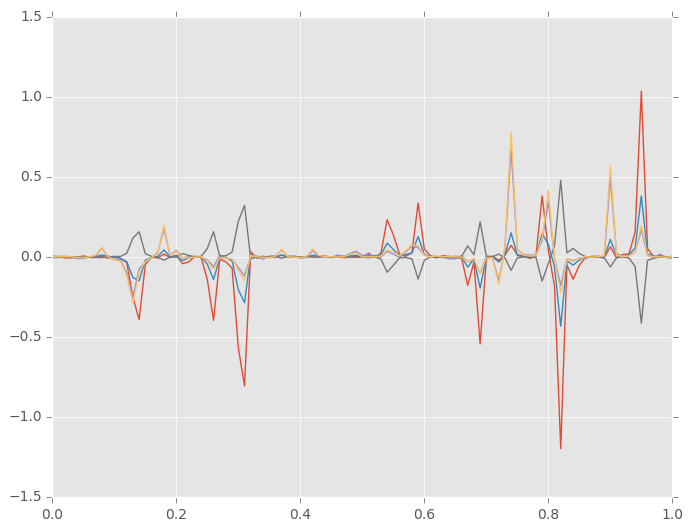

5-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32171db10>
 PyObject <matplotlib.lines.Line2D object at 0x32171dd90>
 PyObject <matplotlib.lines.Line2D object at 0x32171dfd0>
 PyObject <matplotlib.lines.Line2D object at 0x32172b1d0>
 PyObject <matplotlib.lines.Line2D object at 0x32172b390>

In [16]:
plot(tobs, y)

### Write out data

In [14]:
using HDF5

In [17]:
fid = h5open("data/labcr_test_data.jld", "w")

grp = fid["/"]
grp["y"] = y'
grp["theta"] = Theta
grp["psi"] = ψ
grp["xi"] = ξ
grp["Σ0"] = Σ0
grp["tobs"] = tobs

close(fid)